In [1]:
import time
import cv2
import datetime
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from scipy.spatial.distance import cdist
from skimage.feature import hog, local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
def showimage(image, train):
    if train == True:
        plt.imshow(x_train[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (y_train[image])
    else:
        plt.imshow(x_test[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (y_test[image])

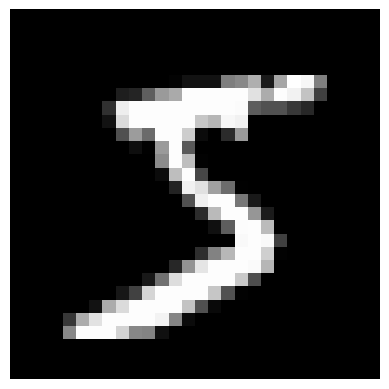

5

In [4]:
showimage(0,1)

# Flatten

In [5]:
def flatten(train, test):
    
    return train.reshape(train.shape[0], -1), test.reshape(test.shape[0], -1)

# PCA

In [6]:
def pca(train, test, variance):
    
    train_flatten, test_flatten = flatten(train, test)
    
    pca = PCA(n_components = variance)
    pca.fit(train_flatten)
    
    return pca.transform(train_flatten), pca.transform(test_flatten)

# SIFT

In [7]:
def sift(train, test, num_cluster):
    
    sift = cv2.SIFT_create()
    
    sift_descriptors_train = []
    for image in train:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_train.append(des)
        
    sift_descriptors_test = []
    for image in test:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_test.append(des)
        
    sift_all_descriptors = []
    for descriptor in sift_descriptors_train:
        if descriptor is not None:
            for des in descriptor:
                sift_all_descriptors.append(des)
                
    sift_bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(sift_all_descriptors)
    sift_bow_dict = kmeans.cluster_centers_
    
    train_sift = []
    for image in sift_descriptors_train:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        train_sift.append(features)

    test_sift = []
    for image in sift_descriptors_test:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        test_sift.append(features)
        
    return np.array(train_sift), np.array(test_sift)

# HOG

In [8]:
def c_hog(train, test, orientations, ppc, cpb):
    
    train_hog = []
    test_hog = []

    for image in train:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        train_hog.append(fd)

    for image in test:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        test_hog.append(fd)
        
    return np.array(train_hog), np.array(test_hog)

# LBP

In [9]:
def lbp(train, test, radius, flat):

    train_lbp = []
    test_lbp = []

    for image in train:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        train_lbp.append(lbp)

    for image in test:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        test_lbp.append(lbp)
        
    train_lbp = np.array(train_lbp)
    test_lbp = np.array(test_lbp)
        
    if flat == True:
        return flatten(train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8))
    else:
        return train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8)

# SIFT + LBP

In [10]:
def siftlbp(train, test, num_cluster, radius):
    
    train_siftlbp, test_siftlbp = lbp(train, test, radius, 0)
    
    return sift(train_siftlbp, test_siftlbp, num_cluster)

# HOG + LBP

In [11]:
def hoglbp(train, test, orientations, ppc, cpb, radius):
    
    train_hoglbp, test_hoglbp = lbp(train, test, radius, 0)
    
    return c_hog(train_hoglbp, test_hoglbp, orientations, ppc, cpb)

# Gaussian Process

In [ ]:
train_gpc, test_gpc = pca(x_train, x_test, 0.8)

In [ ]:
print(train_gpc.shape)
print(test_gpc.shape)

In [ ]:
N = 5000
x = train_gpc[:N]
y = y_train[:N]

In [ ]:
start = time.time()
kernel = RationalQuadratic()
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(x, y)
end = time.time()
print(datetime.timedelta(seconds = int(end-start)))

In [ ]:
y_pred = gpc.predict(test_gpc)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

In [12]:
train_gpc, test_gpc = sift(x_train, x_test, 70)

N = 4000
x = train_gpc[:N]
y = y_train[:N]

start = time.time()
kernel = RationalQuadratic()
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(x, y)
end = time.time()
print(datetime.timedelta(seconds = int(end-start)))

y_pred = gpc.predict(test_gpc)
print(accuracy_score(y_test, y_pred))

C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:38:24
0.6656


In [13]:
train_gpc, test_gpc = c_hog(x_train, x_test, 9, 4, 3)

N = 4000
x = train_gpc[:N]
y = y_train[:N]

start = time.time()
kernel = RationalQuadratic()
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(x, y)
end = time.time()
print(datetime.timedelta(seconds = int(end-start)))

y_pred = gpc.predict(test_gpc)
print(accuracy_score(y_test, y_pred))

C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1:49:41
0.9613


In [14]:
train_gpc, test_gpc = lbp(x_train, x_test, 10, 1)

N = 4000
x = train_gpc[:N]
y = y_train[:N]

start = time.time()
kernel = RationalQuadratic()
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(x, y)
end = time.time()
print(datetime.timedelta(seconds = int(end-start)))

y_pred = gpc.predict(test_gpc)
print(accuracy_score(y_test, y_pred))

C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


2:07:22
0.8622


In [15]:
train_gpc, test_gpc = pca(x_train, x_test, 0.8)

N = 4000
x = train_gpc[:N]
y = y_train[:N]

start = time.time()
kernel = RationalQuadratic()
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(x, y)
end = time.time()
print(datetime.timedelta(seconds = int(end-start)))

y_pred = gpc.predict(test_gpc)
print(accuracy_score(y_test, y_pred))

C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1:05:11
0.923


In [ ]:
# SIFT 0.6656
# HOG 0.9613
# LBP 0.8622
# PCA 0.923